In [9]:
%matplotlib inline

In [27]:
import io
import os
import math
from collections import defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix,dok_matrix, lil_matrix
from sklearn.feature_extraction.text import CountVectorizer,  TfidfTransformer, TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cross_validation import train_test_split

from markov_model.n_gram import NGramModel
from common_lib.lyrics_database import LyricsDatabase
from common_lib.parse_lyrics import parse_lyrics

In [2]:
def generate_lyric(lyrics, n_gram, num_verses=1):
    ghostwriter = NGramModel(lyrics, n_gram)

    print(ghostwriter.n)
    
    history = ['<startVerse>']

    result_lyric = io.StringIO()

    verses = 0 
    counter = 0
    current = ''
    while verses < num_verses and counter < 200:
        nextToken = ghostwriter.genNextToken( history )

        if nextToken == '<startVerse>':
            continue

        if nextToken != '<endLine>' and nextToken != '<endVerse>':
            result_lyric.write(str(nextToken))
            result_lyric.write(' ')
            print(str(nextToken) + ' ', end='')
        elif nextToken == '<endLine>':
            result_lyric.write('\n')
            print()
        elif nextToken == '<endVerse>':
            result_lyric.write('\n\n')
            print()
            print()
            verses += 1

        if len(history) < n_gram-1:
            history.append(nextToken)
        else:
            history.pop(0)
            history.append(nextToken)

        if nextToken == '<endVerse>':
            history = ['<startVerse>']


        current = nextToken
        counter += 1
        
        
    return result_lyric.getvalue()

In [3]:
def create_docs(lyrics_verses, generated_lyrics):
    docs = [generated_lyrics]
    
    is_skip = lambda s : s == '<startVerse>' or s == '<endVerse>' or s == '<endLine>'
    docs.extend([' '.join([t for t in v if not is_skip(t)]) for v in lyrics_verses])
    
    return docs

In [4]:
def calc_similarity(lyrics_verses, generated_lyrics):
    docs = create_docs(lyrics_verses, generated_lyrics)
    N = len(docs)
    
    count_vectorizer = CountVectorizer()
    count_data = count_vectorizer.fit_transform(docs).toarray()

    weight_data = dok_matrix(count_data.shape)

    # save nj
    njs = weight_data.shape[1]*[0]
    for j in range(0, weight_data.shape[1]):
        nnz = 0
        for i in range(0,weight_data.shape[0]):
            if count_data[i,j] != 0:
                nnz += 1
        nj = math.log(N/nnz)
        njs[j] = nj
    print('nj saved!')

    for i in range(0, weight_data.shape[0]):
        for j in range(0, weight_data.shape[1]):
            w = count_data[i,j] * njs[j]
            if w != 0:
                weight_data[i,j] = w
                
    similarities = cosine_similarity(weight_data[0,], weight_data[1:,])
    
    
    return similarities

In [33]:
def save_lyrics(lyrics, filename):
    with open(filename, 'w') as f:
        f.write(lyrics)

Similarity of n-gram model
===============

In [32]:
lyrics_dir = '/data1/nlp-data/ghostwriter/data/top-selling-rappers-cleaned-json'
generated_song_dir = '/data1/nlp-data/ghostwriter/data/generated_lyrics/'

In [ ]:
ld = LyricsDatabase(lyrics_dir)

In [22]:
artists = ld.get_artists_names()
artist = artists[3]

lyrics_verses = ld.get_lyrics_from_artist_as_list_of_verses(artist)
lyrics_one_list = ld.get_lyrics_from_artist_as_plain_list(artist)
print('Artist:', artist, 'Tokens:', len(lyrics_one_list))

Artist: fabolous Tokens: 112448


In [34]:
num_iterations = 5
sim_data = defaultdict(lambda : np.zeros(num_iterations))
for ngram_count in [2,3,4,5,6,7,8,9]:
    for i in range(0,num_iterations):
        generated_lyrics = generate_lyric(lyrics_one_list, ngram_count)
        similarities = calc_similarity(lyrics_verses, generated_lyrics)
        sim_data[ngram_count][i] = similarities.max()
        
        # save lyrics
        name = 'lyrics_ngram' + str(ngram_count) + '_iter' + str(i) + '.txt'
        filename = os.path.join(generated_song_dir,name)
        save_lyrics(generated_lyrics, filename)

2
buy you to give a b s underneath 
mami s beef 
talking bout the clip in the purple broke niggas online reply why wouldn t mind the money y all these mean that we good as yourself 
find in it i m back when a seven digits even quicker to the block like that 
or not tape 3 and talk that the kid s the soul 


nj saved!
2
fabolous strive to know you 
like the shit i know a hoe 
you should i might seem to move that s no 2 3 s dope fiend to get lost somethin ma in a domestic ho your head is gettin through 
couple of rambos 
bbm cool 


nj saved!
2
just to the precinct 
and hang like she a hellichoppers land you still 
that s it s the world see these 
you still here we gon na hug 
never get to grab on the last 
they sit in the check is take the new year i m back of nigga 
they call meee 
nah 
i m the bitches that money talks in st pats socks 


nj saved!
2
call yourself 
clue s with you playing catch up dead if i m squintin like a h3 
niggas throw niggas mouths i ain t even when i just like 

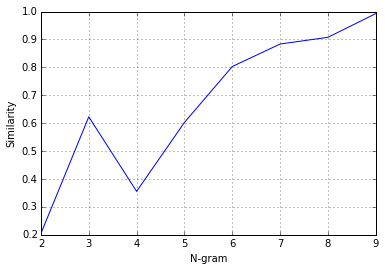

In [35]:
ax = pd.DataFrame(sim_data).mean(0).plot()
ax.set_xlabel("N-gram")
ax.set_ylabel("Similarity")

In [36]:
pd.DataFrame(sim_data)

,2,3,4,5,6,7,8,9
0,0.199683,0.517593,0.222723,1.000000,0.709189,1.000000,0.959635,1.000000
1,0.240751,1.000000,0.234401,0.621820,0.586528,0.965323,0.958361,1.000000
2,0.259071,0.719048,0.364161,0.439185,1.000000,1.000000,0.963978,1.000000
3,0.139823,0.666521,0.329288,0.419997,0.731699,0.483012,0.657256,0.963978
4,0.185969,0.211333,0.627896,0.532948,0.988007,0.970569,1.000000,1.000000


Finding a good example for the presentation
=========================

In [37]:
# temp - find the most similar verse
produced_lirics_test = """
here with the white and the canary cross 
bracelets to match diamonds clear of floss 
convertible hard top in a carrera porsche 
i m young but i m damn near a boss 
and of course your boy ride with a thing in the stash box 
quick to hit the button even quicker to blast shots 
nobody gon na eat less we see chips 
this not even funny not the way we freak chicks 
my waiters make ladies see sick 
i m so so def like a j d remix 
i got enough whips to keep switchin up flavors 
drafted outta high school straight into the majors 
these haters fake smiles but they hardly like me 
they hate to see me rich they d rather see me stuck in the pen 
everytime they walk or pull up beside me 
flash lights in my face askin for my registration and id 
i don t know what imma do but i mma do it 
i got money on my head but im ridin in a drop drop drop drop 
"""

In [82]:
similarities = calc_similarity(lyrics_verses, produced_lirics_test)

nj saved!


In [83]:
print(similarities.shape)
print(similarities.argmax())
print(similarities.max())

(1, 1115)
30
0.731698968519


In [47]:
for t in lyrics_verses[30]:
    if t == '<startVerse>' or t == '<endVerse>':
        continue
    elif t == '<endLine>':
        print()
    else:
        print(t + ' ', end='')


here with the white and the canary cross 
bracelets to match diamonds clear of floss 
convertible hard top in a carrera porsche 
i m young but i m damn near a boss 
and of course your boy ride with a thing in the stash box 
quick to hit the button even quicker to blast shots 
nobody gon na eat less we see chips 
this not even funny not the way we freak chicks 
my waiters make ladies see sick 
i m so so def like a j d remix 
i got enough whips to keep switchin up flavors 
drafted outta high school straight into the majors 
these haters fake smiles but they hardly like me 
they hate to see me in a party icy 
clean white t sippin on bacardi lightly 
suade low cut force one caramel nightly 


Similarity of LSTM
==========

In [49]:
generated_lstm_song_dir = '/data1/nlp-data/ghostwriter/lstm-gen-lyrics/'

In [58]:
sim_data_lstm = defaultdict(float)

iterations = [1000,2000,3000,4000,5000,6000,7000]
for i in iterations:
    filename = os.path.join(generated_lstm_song_dir, 'fabolous' + str(i))
    with open(filename, 'r') as f:
        generated_lyrics = f.readlines()
        generated_lyrics = generated_lyrics[1]
        generated_lyrics = generated_lyrics.replace('<startVerse>', '')
        generated_lyrics = generated_lyrics.replace('<endLine>', '')
        generated_lyrics = generated_lyrics.replace('<endVerse>', '')
        
    sim_data_lstm[i] = calc_similarity(lyrics_verses, generated_lyrics)

nj saved!
nj saved!
nj saved!
nj saved!
nj saved!
nj saved!
nj saved!


In [78]:
iteration_text_manually = {}
iteration_text_manually[7100] = 'i m old enough to know better young enough to not give a fuck  rather hold my head high and die than live and duck  member i had to take the good man and i got the crush with you  i got a deal i was on my coupe it ll ride  i just thought i m gettin a third  hold me the nigga j o  the type i never warn her lady on this s in it  they gon have to a er '
iteration_text_manually[7200] = 'i m in the feds and leave it be like  little me with my road to life i will miss my kin  i m a hustler i dont sling of top shoes are d has like that  i m in a win win and you could beat my man diador  like i was really in these streets i used to serve that shit  we started from the bottom had to topsy turn that shit  get it while the gettins good after that preserve that shit  my swag kicks in that s when the bad guy begins  say hello uh say hello uh  to l o uh to l o s o '

for k in iteration_text_manually.keys():
    generated_lyrics = iteration_text_manually[k]
    sim_data_lstm[k] = calc_similarity(lyrics_verses, generated_lyrics)

nj saved!
nj saved!


In [79]:
sim_data_lstm2 = {}
for k in sim_data_lstm.keys():
    sim_data_lstm2[k] = sim_data_lstm[k].max()

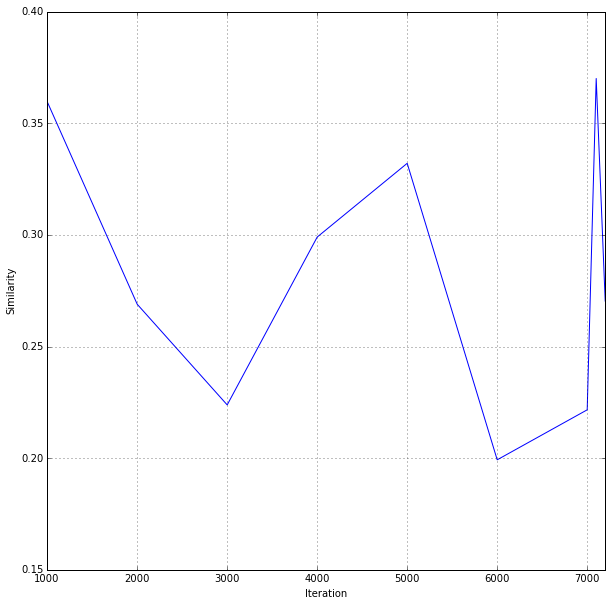

In [81]:
ax = pd.Series(sim_data_lstm2).plot(figsize=(10,10))
ax.set_xlabel("Iteration")
ax.set_ylabel("Similarity")

Similarity of the selected by Peter verse
========================

In [87]:
name = 'fabolous_test_peter'
filename = os.path.join(generated_lstm_song_dir, name)
with open(filename, 'r') as f:
    generated_lyrics = f.readlines()
    generated_lyrics = generated_lyrics[1]
    generated_lyrics = generated_lyrics.replace('<startVerse>', '')
    generated_lyrics = generated_lyrics.replace('<endLine>', '')
    generated_lyrics = generated_lyrics.replace('<endVerse>', '')    

selected_peter_verse_sim = calc_similarity(lyrics_verses, generated_lyrics)

nj saved!


In [89]:
selected_peter_verse_sim.max()

0.41293887934474111